# [ LG에너지솔루션 DX Expert 양성과정 - Transformer #1]

Transformer의 encoder 구조인 BERT를 활용한 text classification

## 강의 복습
강의자료: Transformer
- `Transformer`: Transformer는 Attention의 병렬적 사용을 통해 효율적인 학습이 가능한 구조의 언어 모델. Sequence를 입력으로 받아 sequenc를 출력하는 구조
- `BERT`: Bidirectional Encoder Representations from Transformers의 약자로, 양방향 인코더"

<img src="https://github.com/hwk0702/2024_LG_ES_External_Lecture/blob/main/240703_Transformer/image/Transformer01.png?raw=true" width="400">

## 실습 요약
1. 본 실습에서는 Transformer의 encoder만을 활용한 BERT를 통해 자연어 분류를 수행합니다.

---

## Import modules

In [1]:
!pip install transformers==4.29.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 660.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 446.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 16.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.1/775.1 kB 7.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.3 MB/s eta 0:00:0000:0100:01


In [21]:
# 기본 라이브러리 임포트
import json  # JSON 파일을 읽고 쓰기 위한 라이브러리
import os    # 운영체제와 상호작용하기 위한 라이브러리
import re    # 정규 표현식을 사용하기 위한 라이브러리
import random  # 난수 생성을 위한 라이브러리
import numpy as np  # 수치 연산을 위한 라이브러리
import pandas as pd  # 데이터 처리를 위한 라이브러리
from collections import defaultdict  # 딕셔너리의 기본 값을 설정하기 위한 라이브러리

from time import time  # 시간 측정을 위한 라이브러리
from tqdm.auto import tqdm  # 반복문 진행 상황을 시각적으로 보여주기 위한 라이브러리

# 사이킷런 라이브러리 임포트
from sklearn.model_selection import train_test_split  # 데이터셋을 학습 및 테스트 세트로 분리
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score  # 다양한 평가 지표

# Gensim 라이브러리 임포트
import gensim  # 자연어 처리에 사용되는 라이브러리

# PyTorch 라이브러리 임포트
import torch  # PyTorch 메인 라이브러리
import torch.nn as nn  # 신경망 모듈
import torch.nn.functional as F  # 신경망 함수
from torch.utils.data import Dataset, DataLoader  # 데이터셋 및 데이터로더

# Hugging Face Transformers 라이브러리 임포트
from transformers import AutoTokenizer, BertForSequenceClassification, AdamW  # BERT 모델 및 토크나이저

# 시각화 라이브러리 임포트
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 라이브러리
import seaborn as sns  # 데이터 시각화를 위한 고급 라이브러리

# Seaborn의 플롯 스타일 설정
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

import warnings  # 경고 메시지를 관리하기 위한 모듈
warnings.filterwarnings("ignore")  # 경고 메시지를 무시하도록 설정

## Functions

In [2]:
def torch_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

def calc_metrics(y_true: list, y_score: np.ndarray, y_pred: list) -> dict:
    auroc = roc_auc_score(y_true, y_score)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)

    return {
        'auroc'    : auroc,
        'f1'       : f1,
        'recall'   : recall,
        'precision': precision
    }

def train(model, dataloader, optimizer, log_interval: int, device: str) -> list:

    correct = 0
    total = 0
    total_loss = 0
    total_score = []
    total_preds = []
    total_targets = []

    model.train()

    for i, batch in enumerate(dataloader):
        inputs, attn_mask, targets = batch

        # convert device
        inputs, attn_mask, targets = inputs.to(device), attn_mask.to(device), targets.to(device)

        # model outputs
        outputs = model(inputs, attention_mask=attn_mask, labels=targets)

        # outputs
        loss = outputs[0]
        logit = outputs[1]

        # calculate gradients
        loss.backward()

        # update model weights
        optimizer.step()
        optimizer.zero_grad()

        # total loss and acc
        total_loss += loss.item()
        preds = logit.argmax(dim=1)

        correct += targets.eq(preds).sum().item()
        total += targets.size(0)

        total_score.extend(logit.cpu().tolist())
        total_preds.extend(preds.cpu().tolist())
        total_targets.extend(targets.cpu().tolist())

        # log learning history
        if i % log_interval == 0 or (i+1) == len(dataloader):
            print('TRAIN [%5d/%5d]: Loss: %.3f | Acc: %.3f%% [%5d/%5d]' %
                 (i+1, len(dataloader), total_loss/(i+1), 100.*correct/total, correct, total))

    # calculate metrics
    metrics = calc_metrics(
        y_true  = total_targets,
        y_score = np.array(total_score)[:,1],
        y_pred  = total_preds
    )

    metrics.update([('acc',correct/total), ('loss',total_loss/len(dataloader))])

    # logging metrics
    print('\nTRAIN: Loss: %.3f | Acc: %.3f%% | AUROC: %.3f%% | F1-Score: %.3f%% | Recall: %.3f%% | Precision: %.3f%%\n' %
         (metrics['loss'], 100.*metrics['acc'], 100.*metrics['auroc'], 100.*metrics['f1'], 100.*metrics['recall'], 100.*metrics['precision']))


    return metrics

def test(model, dataloader, log_interval: int, device: str) -> list:

    correct = 0
    total = 0
    total_loss = 0
    total_score = []
    total_preds = []
    total_targets = []

    torch_seed(223)
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            inputs, attn_mask, targets = batch

            # convert device
            inputs, attn_mask, targets = inputs.to(device), attn_mask.to(device), targets.to(device)

            # model outputs
            outputs = model(inputs, attention_mask=attn_mask, labels=targets)

            # outputs
            loss = outputs[0]
            logit = outputs[1]

            # total loss and acc
            total_loss += loss.item()
            preds = logit.argmax(dim=1)

            correct += targets.eq(preds).sum().item()
            total += targets.size(0)

            total_score.extend(logit.cpu().tolist())
            total_preds.extend(preds.cpu().tolist())
            total_targets.extend(targets.cpu().tolist())

            # log learning history
            if i % log_interval == 0 or (i+1) == len(dataloader):
                print('TEST [%5d/%5d]: Loss: %.3f | Acc: %.3f%% [%5d/%5d]' %
                      (i+1, len(dataloader), total_loss/(i+1), 100.*correct/total, correct, total))

    # calculate metrics
    metrics = calc_metrics(
        y_true  = total_targets,
        y_score = np.array(total_score)[:,1],
        y_pred  = total_preds
    )

    metrics.update([('acc',correct/total), ('loss',total_loss/len(dataloader))])

    # logging metrics
    print('\nTEST: Loss: %.3f | Acc: %.3f%% | AUROC: %.3f%% | F1-Score: %.3f%% | Recall: %.3f%% | Precision: %.3f%%\n' %
         (metrics['loss'], 100.*metrics['acc'], 100.*metrics['auroc'], 100.*metrics['f1'], 100.*metrics['recall'], 100.*metrics['precision']))

    # return
    return metrics


def fit(
    model, trainloader, testloader, optimizer, epochs: int, log_interval: int, device: str) -> list:

    train_history = defaultdict(list)
    test_history = defaultdict(list)

    # fitting model
    for i in range(epochs):
        print(f'\nEpoch: [{i+1}/{epochs}]')
        train_metrics = train(
            model        = model,
            dataloader   = trainloader,
            optimizer    = optimizer,
            log_interval = log_interval,
            device       = device,
        )

        test_metrics = test(
            model        = model,
            dataloader   = testloader,
            log_interval = log_interval,
            device       = device
        )

        # stack history
        for k, v in train_metrics.items():
            train_history[k].append(v)
        for k, v in test_metrics.items():
            test_history[k].append(v)

    return train_history, test_history

# Configuration for experiments

In [3]:
class Config:
    """
    실험 설정을 담고 있는 클래스
    """

    # dataset 관련 parameters
    datadir = './data'            # 데이터가 저장된 디렉토리
    dataname = 'naver_shopping.txt' # 데이터 파일 이름
    train_ratio = 0.6             # 학습 데이터셋의 비율
    max_seq_length = 100          # 입력 시퀀스의 최대 길이

    # model
    pretrained_name = 'klue/bert-base' # 사전 학습된 BERT 모델 이름

    # training 관련 parameters
    epochs = 5                    # 총 학습 에폭 수
    batch_size = 32               # 학습 데이터 배치 크기
    test_batch_size = 128         # 테스트 데이터 배치 크기
    learning_rate = 0.00001       # 학습률
    num_workers = 2               # 데이터 로딩을 위한 워커 수
    log_interval = 100            # 로그 출력 간격

    # device
    device = 'cuda'               # 학습을 위한 디바이스 (cuda 또는 cpu)

    # seed
    seed = 223                    # 시드 값 (재현성 확보를 위해 고정)

# Config 클래스의 인스턴스를 생성
cfg = Config()

## Load dataset and dataloader

네이버 쇼핑 리뷰 데이터셋 [[download](https://github.com/bab2min/corpus/tree/master/sentiment)]

In [4]:
!wget -P ./data https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt

--2024-06-30 07:58:59--  https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20623547 (20M) [application/octet-stream]
Saving to: ‘./data/naver_shopping.txt’

naver_shopping.txt  100%[===================>]  19.67M  12.4MB/s    in 1.6s    

2024-06-30 07:59:02 (12.4 MB/s) - ‘./data/naver_shopping.txt’ saved [20623547/20623547]



In [5]:
with open(os.path.join(cfg.datadir, cfg.dataname),'r',encoding='utf-8') as f:
    data = f.readlines()

In [6]:
data[:5]

['5\t배공빠르고 굿\n',
 '2\t택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고\n',
 '5\t아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 엉성하긴 하지만 편하고 가성비 최고예요.\n',
 '2\t선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전화했더니 바로주신다했지만 배송도 누락되어있었네요.. 확인안하고 바로 선물했으면 큰일날뻔했네요..이렇게 배송이 오래걸렸으면 사는거 다시 생각했을거같아요 아쉽네요..\n',
 '5\t민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ\n']

### Preprocessing

In [7]:
# 데이터 처리
rate = []       # 평점을 저장할 리스트
label = []      # 레이블을 저장할 리스트
sentence = []   # 리뷰 텍스트를 저장할 리스트

# 리뷰 데이터를 순회하며 처리
for cur_review in tqdm(data):
    # 평점과 리뷰 텍스트를 탭(\t)으로 분리
    cur_review = cur_review.split('\t')
    
    # 평점을 리스트에 추가
    rate.append(cur_review[0])
    
    # 리뷰 텍스트를 리스트에 추가 (줄바꿈 문자 제거)
    sentence.append(cur_review[1].strip('\n'))
    
    # 평점에 따라 레이블을 할당
    # 평점 4, 5: 긍정 (Positive)
    # 평점 1, 2, 3: 부정 (Negative)
    if int(cur_review[0]) > 3:
        label.append(0)  # 긍정 레이블
    else:
        label.append(1)  # 부정 레이블

  0%|          | 0/200000 [00:00<?, ?it/s]

In [9]:
# 첫 다섯 개의 리뷰 텍스트 출력
print(sentence[:5])

['배공빠르고 굿', '택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고', '아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 엉성하긴 하지만 편하고 가성비 최고예요.', '선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전화했더니 바로주신다했지만 배송도 누락되어있었네요.. 확인안하고 바로 선물했으면 큰일날뻔했네요..이렇게 배송이 오래걸렸으면 사는거 다시 생각했을거같아요 아쉽네요..', '민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ']


In [10]:
# 텍스트 전처리 함수
def preprocess(text):
    # 특수 문자 제거
    text = re.sub('[-=+,#/\?:^$~@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', text)
    # 특정 한글 문자 제거 (예: ㅠ, ㅎ, ㅋ)
    text = re.sub('[ㅠㅎㅋ]', '', text)
    return text

# 정규화된 리뷰 텍스트 리스트
normalize_sentence = []

# 리뷰 텍스트를 순회하며 전처리
for s_i in tqdm(sentence):
    s_i = preprocess(s_i)  # 전처리 함수 적용
    normalize_sentence.append(s_i)  # 전처리된 텍스트 추가

  0%|          | 0/200000 [00:00<?, ?it/s]

In [11]:
print(normalize_sentence[:5])

['배공빠르고 굿', '택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고', '아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 엉성하긴 하지만 편하고 가성비 최고예요.', '선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전화했더니 바로주신다했지만 배송도 누락되어있었네요.. 확인안하고 바로 선물했으면 큰일날뻔했네요..이렇게 배송이 오래걸렸으면 사는거 다시 생각했을거같아요 아쉽네요..', '민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ']


In [12]:
# 사전 학습된 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_name)

# 토큰화할 문장 예시 출력
print('Sentence')
print(normalize_sentence[1])

# 문장 토큰화
print('\nTokenized sentence')
print(tokenizer.tokenize(normalize_sentence[1]))

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Sentence
택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고

Tokenized sentence
['택배', '##가', '엉망', '##이', '##네', '##용', '저희', '##집', '밑', '##에', '##층', '##에', '말', '##도', '##없이', '놔두', '##고', '##가', '##고']


In [13]:
# 샘플링 전 데이터셋 크기 출력
print('Before sampling')
print('len(label): ', len(label))
print('len(normalize_sentence): ', len(normalize_sentence))

# 데이터셋 크기 설정
dataset_size = len(label)

# 샘플링할 인덱스 선택
torch_seed(cfg.seed)
select_idx = np.random.choice(range(dataset_size), size=dataset_size // 2)

# 샘플링된 데이터셋 생성
label = np.array(label)[select_idx]
normalize_sentence = np.array(normalize_sentence)[select_idx]

# 샘플링 후 데이터셋 크기 출력
print('\nAfter sampling')
print('len(label): ', len(label))
print('len(normalize_sentence): ', len(normalize_sentence))

Before sampling
len(label):  200000
len(normalize_sentence):  200000

After sampling
len(label):  100000
len(normalize_sentence):  100000


/tmp/ipykernel_31874/1008093112.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


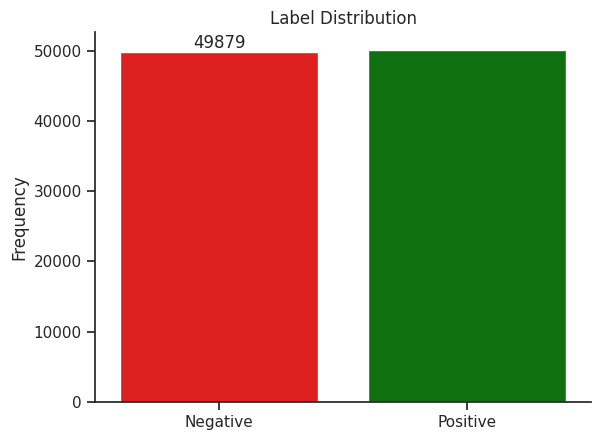

In [17]:
# 레이블 분포 시각화
x, y = np.unique(label, return_counts=True)

# 막대 그래프 생성
palette = ['red', 'green']  # 부정적인 레이블과 긍정적인 레이블의 색상 지정
ax = sns.barplot(x=x, y=y, palette=palette)
plt.title('Label Distribution')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])

# 막대 그래프의 각 막대에 라벨 추가
ax.bar_label(ax.containers[0], fmt='%d')

# 그래프 출력
plt.show()

### Split train and test

In [18]:
# 데이터셋 크기 설정
dataset_size = len(label)

# 시드 설정
torch_seed(cfg.seed)

# 학습 데이터와 테스트 데이터의 인덱스를 분할
train_idx, test_idx = train_test_split(np.arange(dataset_size), train_size=cfg.train_ratio)

# 학습 데이터 설정
x_train = normalize_sentence[train_idx]
y_train = label[train_idx]

# 테스트 데이터 설정
x_test = normalize_sentence[test_idx]
y_test = label[test_idx]

# 학습 데이터와 테스트 데이터의 크기 출력
print('len(x_train): ', len(x_train))
print('len(x_test): ', len(x_test))

len(x_train):  60000
len(x_test):  40000


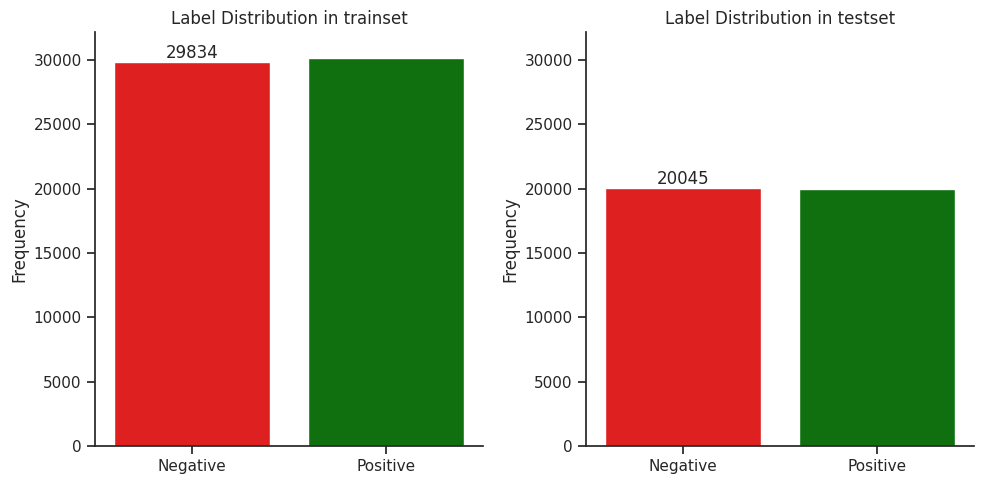

In [22]:
# 서브플롯 생성
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# 학습 데이터셋의 레이블 분포 시각화
x, y = np.unique(y_train, return_counts=True)
sns.barplot(x=x, y=y, ax=ax[0], palette=['red', 'green'])  # 부정적인 레이블은 빨간색, 긍정적인 레이블은 초록색
ax[0].set_title('Label Distribution in trainset')
ax[0].set_ylabel('Frequency')
ax[0].set_xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
ax[0].bar_label(ax[0].containers[0], fmt='%d')
y_max = y.max()

# 테스트 데이터셋의 레이블 분포 시각화
x, y = np.unique(y_test, return_counts=True)
sns.barplot(x=x, y=y, ax=ax[1], palette=['red', 'green'])  # 부정적인 레이블은 빨간색, 긍정적인 레이블은 초록색
ax[1].set_title('Label Distribution in testset')
ax[1].set_ylabel('Frequency')
ax[1].set_xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
ax[1].bar_label(ax[1].containers[0], fmt='%d')
if y_max < y.max():
    y_max = y.max()

# y축의 범위 설정
ax[0].set_ylim(0, y_max + 2000)
ax[1].set_ylim(0, y_max + 2000)

# 레이아웃 조정 및 그래프 출력
plt.tight_layout()
plt.show()

### Build Dataset

In [23]:
class BERTDataset(Dataset):
    def __init__(self, inputs: np.ndarray, targets: np.ndarray, tokenizer: AutoTokenizer, max_seq_length: int = 100):
        """
        BERTDataset 초기화
        :param inputs: 입력 문장 배열
        :param targets: 출력 레이블 배열
        :param tokenizer: 사전 학습된 토크나이저
        :param max_seq_length: 최대 시퀀스 길이
        """
        self.max_seq_length = max_seq_length
        self.tokenizer = tokenizer
        self.inputs = inputs  # input sentence는 input 혹은 source라는 단어로 표현됨
        self.targets = targets  # output label은 target으로 표현됨

        # vocab 설정
        self.vocab = self.tokenizer.vocab
        self.pad_idx = self.vocab['[PAD]']
        self.cls_idx = self.vocab['[CLS]']
        self.sep_idx = self.vocab['[SEP]']
        self.mask_idx = self.vocab['[MASK]']

    def convert_inputs_to_feature(self, input):
        """
        입력 문장을 BERT 모델이 이해할 수 있는 형태로 변환
        :param input: 입력 문장
        :return: 토큰화된 입력 문장
        """
        # STEP 1: 문장을 토큰 단위로 분리한 후 숫자로 변환
        tokenized_input = self.tokenizer.encode(input)

        # STEP 2: 패딩 또는 토큰 자르기
        diff = self.max_seq_length - len(tokenized_input)
        if diff > 0:
            tokenized_input += [self.pad_idx] * diff
        else:
            tokenized_input = tokenized_input[:self.max_seq_length-1] + [self.sep_idx]

        return tokenized_input

    def idx2mask(self, token_ids):
        """
        어텐션 마스크 생성
        :param token_ids: 토큰 ID 리스트
        :return: 어텐션 마스크 리스트
        """
        return [token_id != self.pad_idx for token_id in token_ids]

    def __len__(self):
        """
        데이터셋의 길이 반환
        """
        return len(self.inputs)

    def __getitem__(self, idx):
        """
        주어진 인덱스에 해당하는 데이터 반환
        :param idx: 인덱스
        :return: 토큰화된 입력 문장, 어텐션 마스크, 레이블로 구성된 배치
        """
        input = self.inputs[idx]
        target = self.targets[idx]

        tokenized_input = self.convert_inputs_to_feature(input)
        att_mask = self.idx2mask(tokenized_input)

        # 토큰화된 입력과 어텐션 마스크의 길이가 max_seq_length와 같은지 체크
        assert len(tokenized_input) == self.max_seq_length
        assert len(att_mask) == self.max_seq_length

        batch = [
            torch.tensor(tokenized_input),
            torch.tensor(att_mask),
            torch.tensor(target),
        ]
        return batch

In [24]:
# BERTDataset 인스턴스 생성
trainset = BERTDataset(inputs=x_train, targets=y_train, tokenizer=tokenizer, max_seq_length=cfg.max_seq_length)
testset = BERTDataset(inputs=x_test, targets=y_test, tokenizer=tokenizer, max_seq_length=cfg.max_seq_length)

# DataLoader 인스턴스 생성
trainloader = DataLoader(trainset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
testloader = DataLoader(testset, batch_size=cfg.test_batch_size, shuffle=False, num_workers=cfg.num_workers)

In [25]:
# 학습 데이터셋에서 패딩, CLS, SEP, MASK 토큰의 인덱스를 출력
print('[PAD] index: ', trainset.pad_idx)
print('[CLS] index: ', trainset.cls_idx)
print('[SEP] index: ', trainset.sep_idx)
print('[MASK] index: ', trainset.mask_idx)

[PAD] index:  0
[CLS] index:  2
[SEP] index:  3
[MASK] index:  4


In [26]:
# 학습 데이터셋에서 첫 번째 문장 출력
print('[Sentence]')
print(trainset.inputs[0])

# 첫 번째 문장의 토큰화된 입력 출력
print('\n[Tokenized input]')
print('size: ', len(trainset[0][0]))
print(trainset[0][0])

# 첫 번째 문장의 어텐션 마스크 출력
print('\n[Attention mask]')
print('size: ', len(trainset[0][1]))
print(trainset[0][1])

# 첫 번째 문장의 타깃 레이블 출력
print('\n[Target]')
print(trainset[0][2])

[Sentence]
택배가 인천까지가서 엄청 걱정했는데 월요일날와서 바로 설치 했습니다. 이쁘네요. 재질도 부들부들하고

[Tokenized input]
size:  100
tensor([    2,  9678,  2116,  4068,  2299, 20257,  2112,  4794,  4419,  2371,
        13964, 10132,  2401, 10362,  3785,  4198,  1902,  2219,  3606,    18,
        13854,  2203,  2182,    18, 15495,  2119, 23701, 19521,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

[Attention mask]
size:  100
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, 

## BERT for sequence classification

In [27]:
# 사전 학습된 BERT 모델 로드
model = BertForSequenceClassification.from_pretrained(cfg.pretrained_name)

# 모델을 지정된 디바이스로 이동
model = model.to(cfg.device)

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=cfg.learning_rate)

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [28]:
# 시드 설정
torch_seed(cfg.seed)

# 모델 학습 및 평가
train_history, test_history = fit(
    model        = model,        # 학습시킬 모델
    trainloader  = trainloader,  # 학습 데이터 로더
    testloader   = testloader,   # 테스트 데이터 로더
    optimizer    = optimizer,    # 옵티마이저
    epochs       = cfg.epochs,   # 에포크 수
    log_interval = cfg.log_interval, # 로그 출력 간격
    device       = cfg.device    # 사용할 디바이스
)


Epoch: [1/5]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
TRAIN [    1/ 1875]: Loss: 0.655 | Acc: 59.375% [   19/   32]
TRAIN [  101/ 1875]: Loss: 0.331 | Acc: 87.778% [ 2837/ 3232]
TRAIN [  201/ 1875]: Loss: 0.285 | Acc: 89.692% [ 5769/ 6432]
TRAIN [  301/ 1875]: Loss: 0.266 | Acc: 90.345% [ 8702/ 9632]
TRAIN [  401/ 1875]: Loss: 0.255 | Acc: 90.742% [11644/12832]
TRAIN [  501/ 1875]: Loss: 0

In [29]:
def figure(all_train_history: list, all_test_history: list, all_exp_name: list) -> None:
    """
    성능 지표 시각화 함수
    :param all_train_history: 모든 실험의 학습 데이터 성능 지표 기록
    :param all_test_history: 모든 실험의 테스트 데이터 성능 지표 기록
    :param all_exp_name: 모든 실험의 이름 리스트
    """
    fig, ax = plt.subplots(2, 6, figsize=(20, 7))

    # 학습 데이터 성능 지표 라인 플롯
    for train_h, exp_name in zip(all_train_history, all_exp_name):
        for i, (k, v) in enumerate(train_h.items()):
            sns.lineplot(
                x=range(1, len(v) + 1),
                y=v,
                label=exp_name,
                ax=ax[0, i]
            )
            # y축 레이블 설정
            ax[0, i].set_ylabel(f'{k.upper()}')
            # x축 레이블 설정
            ax[0, i].set_xlabel('Epochs')
            # 제목 설정
            ax[0, i].set_title(f'{k.upper()} of Trainset')
            # 범례 설정
            ax[0, i].legend(loc='lower right')

    # 테스트 데이터 성능 지표 라인 플롯
    for test_h, exp_name in zip(all_test_history, all_exp_name):
        for i, (k, v) in enumerate(test_h.items()):
            sns.lineplot(
                x=range(1, len(v) + 1),
                y=v,
                label=exp_name,
                ax=ax[1, i]
            )
            # y축 레이블 설정
            ax[1, i].set_ylabel(f'{k.upper()}')
            # x축 레이블 설정
            ax[1, i].set_xlabel('Epochs')
            # 제목 설정
            ax[1, i].set_title(f'{k.upper()} of Testset')
            # 범례 설정
            ax[1, i].legend(loc='lower right')

    # 레이아웃 조정 및 그래프 출력
    plt.tight_layout()
    plt.show()

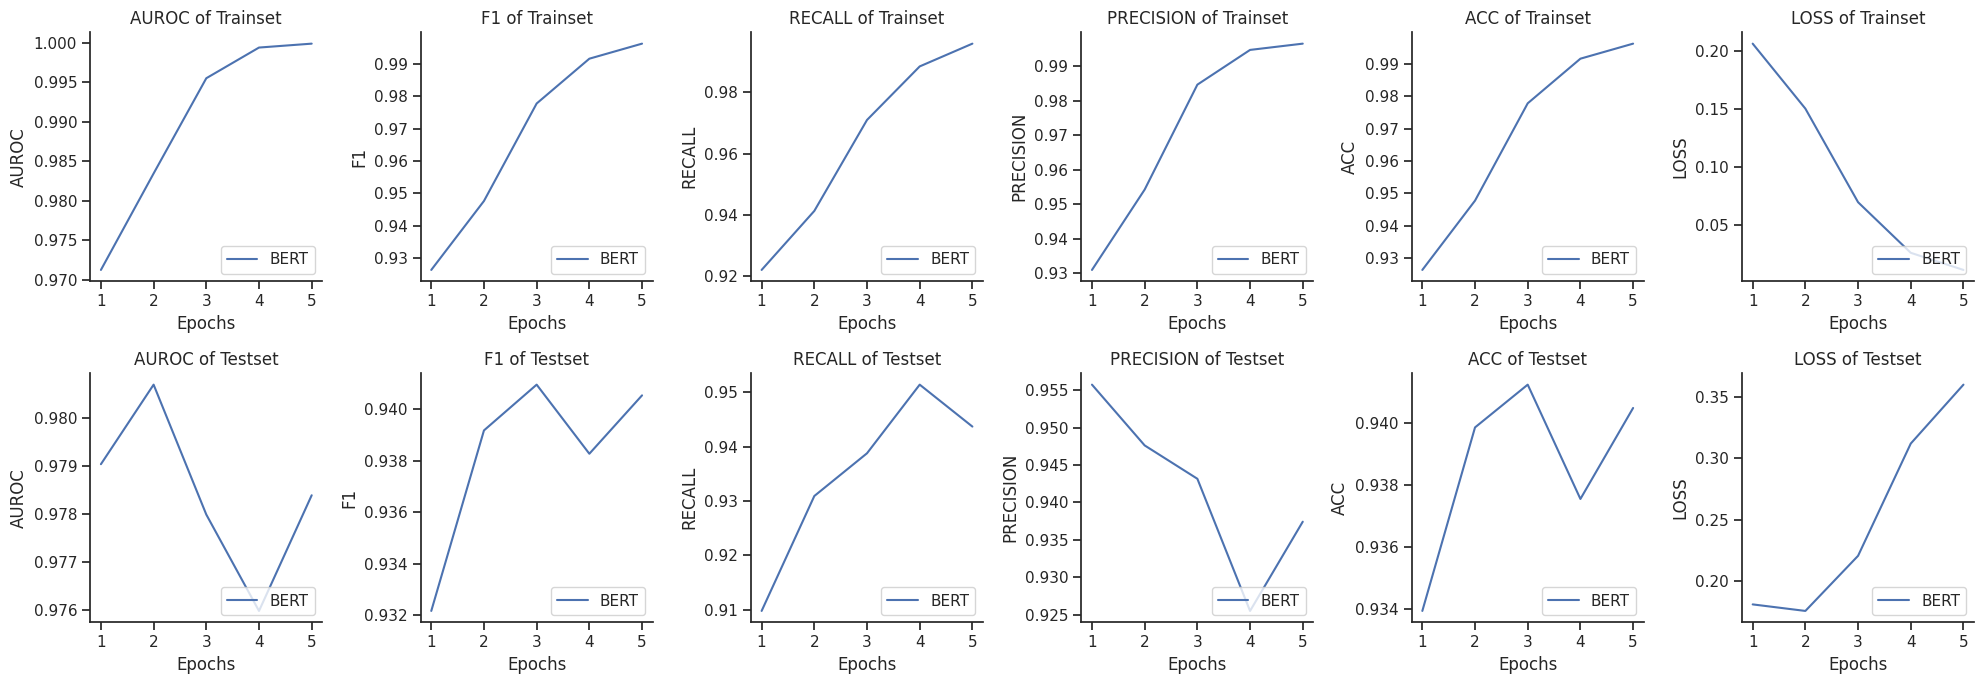

In [30]:
# 학습 및 테스트 데이터 성능 지표 기록
all_train_history = [train_history]
all_test_history = [test_history]
all_exp_name = ['BERT']

# 성능 지표 시각화
figure(
    all_train_history=all_train_history,
    all_test_history=all_test_history,
    all_exp_name=all_exp_name
)

---